In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

import neuro_morpho_toolbox as nmt
# ns=nmt.neuron_set('/Users/pengxie/Documents/Research/fullMorph_classification/data/registered_swc/Janelia_test/swc/Whole/')
ns=nmt.neuron_set('/home/penglab/Documents/Janelia_1000')



/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.93
Loading CCF brain structure data...
Loading time: 0.00
Loading...
100 loaded: 2.6s
Invalid number of soma found: 0
QC failed: AA0114.swc
Invalid number of soma found: 0
QC failed: AA0115.swc
200 loaded: 1.9s
300 loaded: 2.5s
400 loaded: 2.6s
Invalid number of soma found: 0
QC failed: AA0472.swc
500 loaded: 2.9s
Invalid number of soma found: 0
QC failed: AA0576.swc
Invalid number of soma found: 0
QC failed: AA0585.swc
Invalid number of soma found: 0
QC failed: AA0589.swc
600 loaded: 2.7s
Invalid number of soma found: 0
QC failed: AA0639.swc
Invalid number of soma found: 0
QC failed: AA0670.swc
Invalid number of soma found: 0
QC failed: AA0672.swc
700 loaded: 2.5s
Invalid number of soma found: 0
QC failed: AA0754.swc
Invalid number of soma found: 0
QC failed: AA0763.swc
800 loaded: 2.9s
900 loaded: 2.1s
QC failed: AA0952.swc
QC failed: AA0964.swc
QC failed: AA0968.swc
QC

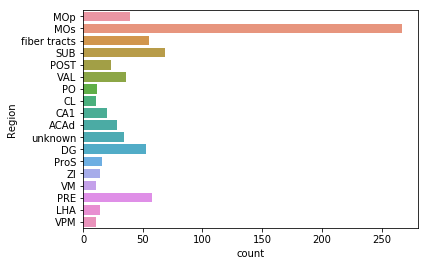

In [2]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)


###  *_as is a dataframe with columns ['swc list', 'soma region', 'max soma', 'total soma', 'max axon']
* rows are corresponding cluster

In [3]:
hier_as = pd.read_excel('/home/penglab/Documents/dataSource/hier_as.xlsx', index_col=0)

kmeans_as = pd.read_excel('/home/penglab/Documents/dataSource/kmeans_as.xlsx', index_col=0)

dbscan_as = pd.read_excel('/home/penglab/Documents/dataSource/dbscan_as.xlsx', index_col=0)

hdbscan_as = pd.read_excel('/home/penglab/Documents/dataSource/hdbscan_as.xlsx', index_col=0)

snn_as = pd.read_excel('/home/penglab/Documents/dataSource/snn_as.xlsx', index_col=0)

## function fromSOMAtoAXON() will return a dataframe 
* first a DataFrame will be generated, 

* **clusterDF** stores the information of clustering result, with columns ['swc list', 'soma region', 'max soma', 'total soma', 'max axon']


In [8]:
import ast
def fromSOMAtoAXON(clusterDF) :
    dfname=[]
    for cluster_idx in clusterDF.index:
        dfname.append((str(cluster_idx) + 'DF'))

    #generate a dataframe for each cluster
    dicDF = {k:None for k in dfname}

    #iterate the correponding dataframe and cluster at the same time
    for key_iter,cluster_idx in zip(dicDF.keys(),clusterDF.index):
        dic_soma = ast.literal_eval(clusterDF.loc[cluster_idx,'max soma'])
        iterL = int(len(dic_soma.keys())/2)
        somaNAME = []
        somaCOUNT = []

        for i in range(1,int(iterL)+1):
            somaNAME.append(dic_soma[(str(i)+'somaR')])
        for i in range(1,iterL+1):
            somaCOUNT.append(dic_soma[str(i)+'somaC'])
        somaArr = np.array(somaCOUNT, dtype = float)
        somaArr = somaArr/sum(somaArr)
        dic_axon = ast.literal_eval(clusterDF.loc[cluster_idx,'max axon'])
        iterL = int(len(dic_axon.keys())/2)
        axonNAME = []
        axonCOUNT = []
        for i in range(1,iterL+1):
            axonNAME.append(dic_axon[(str(i)+'axonR')])
        for i in range(1,iterL+1):
            axonCOUNT.append(dic_axon[str(i)+'axonC']) 

        tempDF = pd.DataFrame()
        for row_soma in somaNAME:
            for col_axon,len_axon in zip(axonNAME,axonCOUNT):
            #***************NOTE WE HAVE NOT USE somaCOUNT yet
                tempDF.loc[row_soma, col_axon] = len_axon

        assert(tempDF.shape[0] == len(somaArr))  
        tempDF=tempDF.astype(float)
        for i in range(tempDF.shape[0]):
            tempDF.iloc[i,:] = tempDF.iloc[i,:]*somaArr[i].copy()

        newDF = pd.DataFrame(columns=['from','to','value'],index=range(tempDF.shape[0]*tempDF.shape[1]))
        newDF.loc[:,'from'] = (tempDF.index).tolist()*len(tempDF.columns)
        newDF.loc[:,'to'] = [ele for ele in (tempDF.columns).tolist() for _ in range(len(tempDF.index))]
        valuelist=[]
        for iter_col in tempDF.columns:
            for iter_row in tempDF.index:
                valuelist.append(tempDF.loc[iter_row,iter_col])
        newDF.loc[:,'value']=valuelist
        dicDF[key_iter]= newDF.copy()
    return dicDF

In [9]:
dicHIER = fromSOMAtoAXON(hier_as)
dicKMEANS = fromSOMAtoAXON(kmeans_as)
dicDBSCAN = fromSOMAtoAXON(dbscan_as)
dicHDBSCAN = fromSOMAtoAXON(hdbscan_as)
dicSNN = fromSOMAtoAXON(snn_as)

In [10]:
type(dicHIER['C1DF'])

pandas.core.frame.DataFrame

for iter_key in dicHIER.keys():
    tempDF = dicHIER[iter_key]
    print(tempDF)
    (tempDF).to_csv('/home/penglab/Documents/dataSource/dfSET/HIER/'+str(iter_key)+'.csv')

for iter_key in dicKMEANS.keys():
    tempDF = dicKMEANS[iter_key]
    print(tempDF)
    (tempDF).to_csv('/home/penglab/Documents/dataSource/dfSET/KMEANS/'+str(iter_key)+'.csv')

for iter_key in dicDBSCAN.keys():
    tempDF = dicDBSCAN[iter_key]
    pd.DataFrame(tempDF).to_csv('/home/penglab/Documents/dataSource/dfSET/DBSCAN/'+str(iter_key)+'.csv')

for iter_key in dicHDBSCAN.keys():
    tempDF = dicHDBSCAN[iter_key]
    pd.DataFrame(tempDF).to_csv('/home/penglab/Documents/dataSource/dfSET/HDBSCAN/'+str(iter_key)+'.csv')

for iter_key in dicSNN.keys():
    tempDF = dicSNN[iter_key]
    pd.DataFrame(tempDF).to_csv('/home/penglab/Documents/dataSource/dfSET/SNN/'+str(iter_key)+'.csv')

In [12]:
nodes = data['nodes']
links = data['links']

nodes_df = pd.DataFrame(nodes)
links_df = pd.DataFrame(links)

source_data = links_df.merge(nodes_df, how='left', left_on='source', right_index=True)
source_data = source_data.merge(nodes_df, how='left', left_on='target', right_index=True)
source_data = source_data[source_data["value"] > 5]
source_data

chord_from_df = Chord(source_data, source="name_x", target="name_y", value="value")
output_file('chord-diagram-bokeh.html', mode="inline")
show(chord_from_df)


NameError: name 'data' is not defined

 function createDISTRItable (regionlist,CCFlist, clusterDF) will return a np.array, a square matrix 
* first a DataFrame will be generated, 
* **regionlist** is the ***columns*** for the dataframe: ns.features['projection_features'].raw_data.columns.tolist()
    * corresponding to the axon region(ispi- and contra- is considered)
* **CCFlist** is the ***rows*** for the dataframe: 
    * corresponding to the soma region(not consider ispi- and contra-)
* **clusterDF** stores the information of clustering result, with columns ['swc list', 'soma region', 'max soma', 'total soma', 'max axon']



Initial Idea:
we can generate a separate dataframe for different cluster, then sum it up
now neglect the rank of the three regions

def createDISTRItable(regionlist,CCFlist,clusterDF):
    dfname=[]
    for cluster_idx in clusterDF.index:
        dfname.append((str(cluster_idx) + 'DF'))

    #generate a dataframe for each cluster
    dicDF = {name: pd.DataFrame(index = CCFlist , columns=regionlist) for name in dfname}
    dicnewDF = {}
    #iterate the correponding dataframe and cluster at the same time
    for key_iter,cluster_idx in zip(dicDF.keys(),clusterDF.index):
        tempDF = dicDF[key_iter].copy()
        dic_soma = ast.literal_eval(clusterDF.loc[cluster_idx,'max soma'])
        iterL = int(len(dic_soma.keys())/2)
        somaNAME = []
        somaCOUNT = []
        for i in range(1,int(iterL)+1):
            somaNAME.append(dic_soma[(str(i)+'somaR')])
        for i in range(1,iterL+1):
            somaCOUNT.append(dic_soma[str(i)+'somaC'])

        dic_axon = ast.literal_eval(clusterDF.loc[cluster_idx,'max axon'])
        iterL = int(len(dic_axon.keys())/2)
        axonNAME = []
        axonCOUNT = []
        for i in range(1,iterL+1):
            axonNAME.append(dic_axon[(str(i)+'axonR')])
        for i in range(1,iterL+1):
            axonCOUNT.append(dic_axon[str(i)+'axonC'])    
        for row_soma in somaNAME:
            for col_axon,len_axon in zip(axonNAME,axonCOUNT):
            #***************NOTE WE HAVE NOT USE somaCOUNT yet
                if row_soma in tempDF.index:
                    tempDF.loc[row_soma, col_axon] = len_axon
        tempDF [tempDF.isnull()]=0
        assert(dicDF[key_iter].shape==tempDF.shape)
        dicnewDF[key_iter]= tempDF.copy()
    return dicnewDF



In [201]:
CCF_list=[]
for i in nmt.bs.selected_regions:
    CCF_list.append(nmt.bs.level.loc[i, "Abbrevation"])

In [ ]:
.to_excel('/home/penglab/Documents/dataSource/snn_as.xlsx')